In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
import sys
import json

from IPython.display import clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [3]:
sys.path.append('../scripts')

In [4]:
YOLO_DATA_PATH = '../.data/animal'
YOLO_DATA_YAML = '../.data/animal/data.yaml'

In [5]:
df_results = pd.DataFrame(columns=['model', 'test_animal_accuracy', 'test_non_animal_accuracy', 'test_accuracy', 'pytorch_size_kb', 'onnx_size_kb'])
if os.path.exists('../data/results.csv'):
    df_results = pd.read_csv('../data/results.csv')
def add_result(*, model, test_animal_accuracy, test_non_animal_accuracy, test_accuracy, pytorch_size_kb, onnx_size_kb):
    global df_results
    new_result = pd.DataFrame({
        'model': [model],
        'test_animal_accuracy': [test_animal_accuracy],
        'test_non_animal_accuracy': [test_non_animal_accuracy],
        'test_accuracy': [test_accuracy],
        'pytorch_size_kb': [pytorch_size_kb],
        'onnx_size_kb': [onnx_size_kb],
    })
    if df_results.empty:
        df_results = new_result
    else:
        df_results = pd.concat([df_results, new_result], ignore_index=True)
    display(df_results.iloc[[-1]])
    df_results.to_csv('../data/results.csv', index=False)

# Baselines

## Always Guess the Most Frequent Label

In [13]:
num_test_animals = len(os.listdir(os.path.join(YOLO_DATA_PATH, 'test', 'animal')))
num_test_non_animals = len(os.listdir(os.path.join(YOLO_DATA_PATH, 'test', 'non-animal')))

add_result(
    model='GuessMostFrequent',
    test_animal_accuracy=1 if num_test_animals > num_test_non_animals else 0,
    test_non_animal_accuracy=0 if num_test_animals > num_test_non_animals else 1,
    test_accuracy=max(num_test_animals, num_test_non_animals) / (num_test_animals + num_test_non_animals),
    pytorch_size_kb=0,
    onnx_size_kb=0,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
0,GuessMostFrequent,1.0,0.0,0.53017,0.0,0.0


## Pretrained (Unquantized/Unfinetuned/Unpruned) YOLOv8 Nano

In [9]:
model = YOLO("../.data/yolov8n-cls.pt")
model.info()

YOLOv8n-cls summary: 99 layers, 2,719,288 parameters, 0 gradients, 4.4 GFLOPs


(99, 2719288, 0, 4.383948800000001)

### Classify whether each existing class is an animal or not

In [10]:
animal_classes = set()
non_animal_classes = set()

if os.path.exists("../data/animal_classes.json") and os.path.exists("../data/non_animal_classes.json"):
    with open("../data/animal_classes.json", "r") as f:
        animal_classes = set(json.load(f))
    with open("../data/non_animal_classes.json", "r") as f:
        non_animal_classes = set(json.load(f))
else:
    from mlx_lm import load, generate
    llm, tokenizer = load("mlx-community/Mistral-7B-Instruct-v0.3-4bit")

    def is_thing_animal(thing):
        prompt = f'The statement "a {thing} is a type of animal" is (true/false): '
        messages = [{"role": "user", "content": prompt}]
        prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        ) # type: ignore
        text = generate(llm, tokenizer, prompt=prompt)
        return "true" in text.lower()

    for thing in model.names.values():
        if is_thing_animal(thing):
            animal_classes.add(thing)
        else:
            non_animal_classes.add(thing)

    # save sets as json
    with open("../data/animal_classes.json", "w") as f:
        json.dump(list(animal_classes), f)
    with open("../data/non_animal_classes.json", "w") as f:
        json.dump(list(non_animal_classes), f)

print(len(animal_classes), len(non_animal_classes))

295 705


### Determine the optimal top_k

In [11]:
def evaluate_pretrained_yolo(dataset, top_k=5):
    assert top_k > 0 and top_k <= 5
    assert dataset in ['train', 'test', 'val']

    num_animals = 0
    num_detected_animals = 0
    for animal_result in model(os.path.join(YOLO_DATA_PATH, dataset, 'animal'), verbose=False, stream=True):
        num_animals += 1
        for cls in animal_result.probs.top5[:top_k]:
            if animal_result.names[cls] in animal_classes:
                num_detected_animals += 1
                break

    num_non_animals = 0
    num_detected_non_animals = 0
    for non_animal_result in model(os.path.join(YOLO_DATA_PATH, dataset, 'non-animal'), verbose=False, stream=True):
        num_non_animals += 1
        is_animal = False
        for cls in non_animal_result.probs.top5[:top_k]:
            if non_animal_result.names[cls] in animal_classes:
                is_animal = True
                break
        if not is_animal:
            num_detected_non_animals += 1

    animal_accuracy = num_detected_animals / num_animals
    non_animal_accuracy = num_detected_non_animals / num_non_animals
    overall_accuracy = (num_detected_animals + num_detected_non_animals) / (num_animals + num_non_animals)

    return animal_accuracy, non_animal_accuracy, overall_accuracy

In [14]:
# only consider top 1 class
animal_accuracy, non_animal_accuracy, overall_accuracy = evaluate_pretrained_yolo('val', top_k=1)
print("Animal Accuracy", animal_accuracy)
print("Non Animal Accuracy", non_animal_accuracy)
print("Overall Accuracy", overall_accuracy)

Animal Accuracy 0.713970182219768
Non Animal Accuracy 0.8629283489096573
Overall Accuracy 0.7839578454332553


In [15]:
# find the best value of top_k
best_top_k = 1
best_overall_accuracy = overall_accuracy
for top_k in range(2, 6):
    animal_accuracy, non_animal_accuracy, overall_accuracy = evaluate_pretrained_yolo('val', top_k=top_k)
    if overall_accuracy > best_overall_accuracy:
        best_top_k = top_k
        best_overall_accuracy = overall_accuracy

print("Best top_k", best_top_k)
print("Best Overall Accuracy", best_overall_accuracy)

Best top_k 2
Best Overall Accuracy 0.8694379391100703


In [16]:
# evaluate on test set
animal_accuracy, non_animal_accuracy, overall_accuracy = evaluate_pretrained_yolo('test', top_k=best_top_k)
print("Animal Accuracy", animal_accuracy)
print("Non Animal Accuracy", non_animal_accuracy)
print("Overall Accuracy", overall_accuracy)

Animal Accuracy 0.8795580110497238
Non Animal Accuracy 0.7955112219451371
Overall Accuracy 0.8400702987697716


In [17]:
# model size as onnx
model.export(format="onnx", simplify=True, project="../.data/", name="yolov8n-cls.onnx", verbose=False, half=True)
clear_output()
onnx_size_kb = os.path.getsize("../.data/yolov8n-cls.onnx") / 1e3
print("ONNX Model Size", onnx_size_kb / 1e3, "MB")

# model size as pytorch
pytorch_size_kb = os.path.getsize("../.data/yolov8n-cls.pt") / 1e3
print("Pytorch Model Size", pytorch_size_kb / 1e3, "MB")


ONNX Model Size 10.905376 MB
Pytorch Model Size 5.563076 MB


In [19]:
add_result(
    model='YOLOv8n-CLS',
    test_animal_accuracy=animal_accuracy,
    test_non_animal_accuracy=non_animal_accuracy,
    test_accuracy=overall_accuracy,
    pytorch_size_kb=pytorch_size_kb,
    onnx_size_kb=onnx_size_kb,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
1,YOLOv8n-CLS,0.879558,0.795511,0.84007,5563.076,10905.376


# Custom-trained CNN

In [6]:
import torch
_ = torch.manual_seed(42)

In [7]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() or 2
IMG_SIZE = 224

In [8]:
from YOLODataset import YOLODataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = YOLODataset(os.path.join(YOLO_DATA_PATH, 'train', 'animal'), os.path.join(YOLO_DATA_PATH, 'train', 'non-animal'), transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

valset = YOLODataset(os.path.join(YOLO_DATA_PATH, 'val', 'animal'), os.path.join(YOLO_DATA_PATH, 'val', 'non-animal'), transform=transform)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

testset = YOLODataset(os.path.join(YOLO_DATA_PATH, 'test', 'animal'), os.path.join(YOLO_DATA_PATH, 'test', 'non-animal'), transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


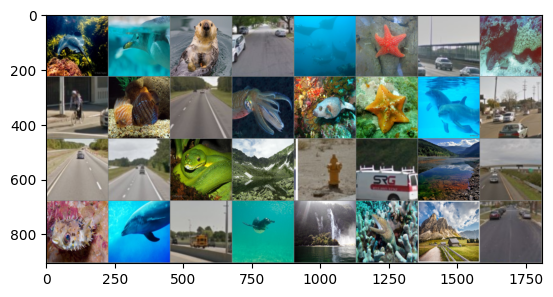

animal animal animal non-animal animal animal non-animal animal non-animal animal non-animal animal animal animal animal non-animal non-animal non-animal animal non-animal non-animal non-animal non-animal non-animal animal animal non-animal animal non-animal animal non-animal non-animal


In [9]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{trainset.classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.quantization

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 6, 5)
        v = ((IMG_SIZE - 5 + 1) // 2 - 5 + 1) // 2
        self.fc1 = nn.Linear(6 * v * v, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 2)

    def forward(self, x):
        x = self.quant(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dequant(x)
        return x


net = Net()
torch.backends.quantized.engine = 'qnnpack'
net.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')
_ = torch.quantization.prepare_qat(net, inplace=True)

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
NUM_EPOCHS = 10
SHOW_STATS_EVERY_NTH_BATCH = 10
best_val = float('inf')
best_model = None
for epoch in range(NUM_EPOCHS):
    net.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % SHOW_STATS_EVERY_NTH_BATCH == SHOW_STATS_EVERY_NTH_BATCH - 1:    # print every 10th batch
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / SHOW_STATS_EVERY_NTH_BATCH:.3f}')
            running_loss = 0.0

    quantized_model = torch.quantization.convert(net.eval(), inplace=False)
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = quantized_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(valloader)
    print(f'Epoch {epoch + 1} Validation loss: {val_loss:.3f}')

    torch.save(quantized_model, f"../data/animal_cnn_cp{epoch + 1}.pt")

    if val_loss < best_val:
        best_val = val_loss
        best_model = quantized_model

print('Finished Training')
clear_output()

In [23]:
torch.save(best_model, f"../data/animal_cnn_{IMG_SIZE}_small.pt")

In [24]:
# print size
pytorch_size_kb = os.path.getsize(f"../data/animal_cnn_{IMG_SIZE}_small.pt") / 1e3
print("Pytorch Model Size", pytorch_size_kb / 1e3, "MB")

Pytorch Model Size 0.414018 MB


In [26]:
assert best_model is not None
correct = 0
total = 0
animal_correct = 0
animal_total = 0
non_animal_correct = 0
non_animal_total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        animal_total += (labels == 0).sum().item()
        non_animal_total += (labels == 1).sum().item()
        animal_correct += ((predicted == labels) & (labels == 0)).sum().item()
        non_animal_correct += ((predicted == labels) & (labels == 1)).sum().item()

print(f'Accuracy: {100 * correct // total}%')
print(f'Animal Accuracy: {100 * animal_correct // animal_total}%')
print(f'Non Animal Accuracy: {100 * non_animal_correct // non_animal_total}%')

Accuracy: 86%
Animal Accuracy: 92%
Non Animal Accuracy: 79%


In [27]:
add_result(
    model='CNN Small',
    test_animal_accuracy=animal_correct / animal_total,
    test_non_animal_accuracy=non_animal_correct / non_animal_total,
    test_accuracy=correct / total,
    pytorch_size_kb=pytorch_size_kb,
    onnx_size_kb=np.nan,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
2,CNN Small,0.923204,0.797382,0.864089,414.018,NaN


In [79]:
yolo_sized_cnn = torch.load(f"../data/animal_cnn_{IMG_SIZE}.pt")
yolo_sized_cnn.conv1._backward_hooks = {}
yolo_sized_cnn.conv1._backward_pre_hooks = {}
yolo_sized_cnn.conv1._forward_hooks = {}
yolo_sized_cnn.conv1._forward_pre_hooks = {}
yolo_sized_cnn.conv2._backward_hooks = {}
yolo_sized_cnn.conv2._backward_pre_hooks = {}
yolo_sized_cnn.conv2._forward_hooks = {}
yolo_sized_cnn.conv2._forward_pre_hooks = {}

In [80]:
# print size
pytorch_size_kb = os.path.getsize(f"../data/animal_cnn_{IMG_SIZE}.pt") / 1e3
print("Pytorch Model Size", pytorch_size_kb / 1e3, "MB")

Pytorch Model Size 5.414498 MB


In [81]:
correct = 0
total = 0
animal_correct = 0
animal_total = 0
non_animal_correct = 0
non_animal_total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = yolo_sized_cnn(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        animal_total += (labels == 0).sum().item()
        non_animal_total += (labels == 1).sum().item()
        animal_correct += ((predicted == labels) & (labels == 0)).sum().item()
        non_animal_correct += ((predicted == labels) & (labels == 1)).sum().item()

print(f'Accuracy: {100 * correct // total}%')
print(f'Animal Accuracy: {100 * animal_correct // animal_total}%')
print(f'Non Animal Accuracy: {100 * non_animal_correct // non_animal_total}%')

Accuracy: 90%
Animal Accuracy: 87%
Non Animal Accuracy: 93%


In [31]:
add_result(
    model='CNN YOLOv8n-sized',
    test_animal_accuracy=animal_correct / animal_total,
    test_non_animal_accuracy=non_animal_correct / non_animal_total,
    test_accuracy=correct / total,
    pytorch_size_kb=pytorch_size_kb,
    onnx_size_kb=np.nan,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
3,CNN YOLOv8n-sized,0.870166,0.935786,0.900996,5414.498,NaN


# Custom YOLOv8 Nano (Quantized/Finetuned/Pruned)

### Start with a simple finetune (no quantization/pruning)
Should be smaller since it is more specialized (fewer classes) and we are using a fixed 224x224 input size.

In [ ]:
model = YOLO("../.data/yolov8n-cls.pt")
model.info()

YOLOv8n-cls summary: 99 layers, 2,719,288 parameters, 0 gradients, 4.4 GFLOPs


(99, 2719288, 0, 4.383948800000001)

In [40]:
results = model.train(data=YOLO_DATA_PATH, epochs=10, imgsz=224, project='../data/yolo-finetune/', name='10_epochs_224_imgsz', save_dir='')
clear_output()

In [41]:
# Validation results
overall_accuracy = results.top1
print("Overall Accuracy", overall_accuracy)
animal_accuracy = results.confusion_matrix.matrix[0, 0] / results.confusion_matrix.matrix[0].sum()
print("Animal Accuracy", animal_accuracy)
non_animal_accuracy = results.confusion_matrix.matrix[1, 1] / results.confusion_matrix.matrix[1].sum()
print("Non Animal Accuracy", non_animal_accuracy)

Overall Accuracy 0.98741215467453
Animal Accuracy 0.9983089064261556
Non Animal Accuracy 0.9756394640682094


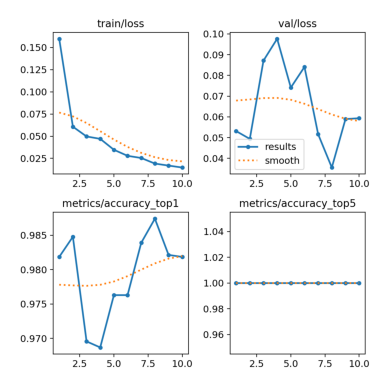

In [ ]:
training_curve = plt.imread('../data/yolo-finetune/10_epoch_224_imgsz/results.png')
plt.imshow(training_curve)
plt.axis('off')
plt.show()

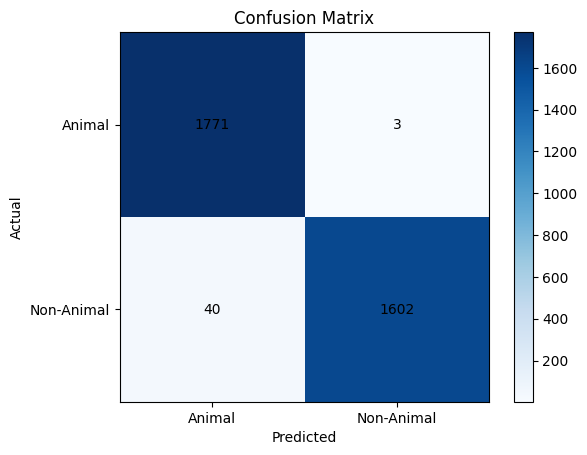

In [ ]:
# plot confusion matrix
plt.imshow(results.confusion_matrix.matrix, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['Animal', 'Non-Animal'])
plt.yticks([0, 1], ['Animal', 'Non-Animal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(results.confusion_matrix.matrix[i, j]), ha='center', va='center', color='black')
plt.show()

In [104]:
def eval_yolo(model: YOLO, dataset):
    assert dataset in ['train', 'test', 'val']

    num_animals = 0
    num_detected_animals = 0
    for animal_result in model(os.path.join(YOLO_DATA_PATH, dataset, 'animal'), verbose=False, stream=True):
        num_animals += 1
        if animal_result.names[animal_result.probs.top1] == 'animal':
            num_detected_animals += 1

    num_non_animals = 0
    num_detected_non_animals = 0
    for non_animal_result in model(os.path.join(YOLO_DATA_PATH, dataset, 'non-animal'), verbose=False, stream=True):
        num_non_animals += 1
        if non_animal_result.names[non_animal_result.probs.top1] == 'non-animal':
            num_detected_non_animals += 1

    animal_accuracy = num_detected_animals / num_animals
    non_animal_accuracy = num_detected_non_animals / num_non_animals
    overall_accuracy = (num_detected_animals + num_detected_non_animals) / (num_animals + num_non_animals)

    return animal_accuracy, non_animal_accuracy, overall_accuracy

In [ ]:
yolo_model = YOLO("../data/yolo-finetune/10_epoch_224_imgsz/weights/best.pt")
yolo_model.info()

YOLOv8n-cls summary: 99 layers, 1,440,850 parameters, 0 gradients, 3.4 GFLOPs


(99, 1440850, 0, 3.3619968)

In [ ]:
animal_accuracy, non_animal_accuracy, overall_accuracy = eval_yolo(yolo_model, 'test')
print("Animal Accuracy", animal_accuracy)
print("Non Animal Accuracy", non_animal_accuracy)
print("Overall Accuracy", overall_accuracy)

Animal Accuracy 0.987292817679558
Non Animal Accuracy 0.9950124688279302
Overall Accuracy 0.9909197422378442


In [47]:
# model size as onnx
yolo_model.export(format="onnx", simplify=True, project="../data/yolo-finetune/10_epoch_224_imgsz", name="best.onnx", verbose=False, half=True)
clear_output()
onnx_size_kb = os.path.getsize("../data/yolo-finetune/10_epoch_224_imgsz/weights/best.onnx") / 1e3
print("ONNX Model Size", onnx_size_kb / 1e3, "MB")

# model size as pytorch
pytorch_size_kb = os.path.getsize("../data/yolo-finetune/10_epoch_224_imgsz/weights/best.pt") / 1e3
print("Pytorch Model Size", pytorch_size_kb / 1e3, "MB")

ONNX Model Size 5.773233 MB
Pytorch Model Size 2.962497 MB


In [48]:
add_result(
    model='YOLOv8n-CLS Fine-tuned',
    test_animal_accuracy=animal_accuracy,
    test_non_animal_accuracy=non_animal_accuracy,
    test_accuracy=overall_accuracy,
    pytorch_size_kb=pytorch_size_kb,
    onnx_size_kb=onnx_size_kb,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
4,YOLOv8n-CLS Fine-tuned,0.987293,0.995012,0.99092,2962.497,5773.233


### Quantize the model

In [14]:
import cv2
import onnxruntime as ort

def eval_onnx(model, dataset, proportion=1.0):
    assert dataset in ['train', 'test', 'val']


    def predict(image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
        image = np.expand_dims(image, axis=0).astype('float32') / 255.
        image = np.transpose(image, [0, 3, 1, 2])
        outputs = model.run(None, {'images': image})
        predicted = 'animal' if outputs[0][0][0] > outputs[0][0][1] else 'non-animal'
        return predicted

    num_animals = 0
    num_detected_animals = 0
    animal_images = os.listdir(os.path.join(YOLO_DATA_PATH, dataset, 'animal'))
    if proportion < 1.0:
        animal_images = animal_images[:int(proportion * len(animal_images))]
    for animal_image in animal_images:
        num_animals += 1
        if predict(cv2.imread(os.path.join(YOLO_DATA_PATH, dataset, 'animal', animal_image))) == 'animal':
            num_detected_animals += 1

    num_non_animals = 0
    num_detected_non_animals = 0
    non_animal_images = os.listdir(os.path.join(YOLO_DATA_PATH, dataset, 'non-animal'))
    if proportion < 1.0:
        non_animal_images = non_animal_images[:int(proportion * len(non_animal_images))]
    for non_animal_image in non_animal_images:
        num_non_animals += 1
        if predict(cv2.imread(os.path.join(YOLO_DATA_PATH, dataset, 'non-animal', non_animal_image))) == 'non-animal':
            num_detected_non_animals += 1

    animal_accuracy = num_detected_animals / num_animals
    non_animal_accuracy = num_detected_non_animals / num_non_animals
    overall_accuracy = (num_detected_animals + num_detected_non_animals) / (num_animals + num_non_animals)

    return animal_accuracy, non_animal_accuracy, overall_accuracy

#### Dynamic Quantization
Only the weights, not the activations, are quantized ahead of time.
The activations are quantized on the fly during inference.

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

# Preprocess float32 model
!cd ../data/yolo-finetune/10_epoch_224_imgsz/weights && python -m onnxruntime.quantization.preprocess --input best.onnx --output preprocessed.onnx

model_fp32 = '../data/yolo-finetune/10_epoch_224_imgsz/weights/preprocessed.onnx'
model_int8 = '../data/yolo-finetune/10_epoch_224_imgsz/weights/dynamic_quantized.onnx'

# Quantize 
quantize_dynamic(model_fp32, model_int8, weight_type=QuantType.QUInt8)

# model size as onnx
onnx_size_kb = os.path.getsize(model_int8) / 1e3
print("ONNX Model Size", onnx_size_kb / 1e3, "MB")
# note: pytorch dynamic quantization does not support convolutional layers, so we use onnxruntime for quantization

ONNX Model Size 1.508519 MB


In [ ]:
# Evaluate the quantized model
onnx_model = ort.InferenceSession('../data/yolo-finetune/10_epoch_224_imgsz/weights/dynamic_quantized.onnx')

animal_accuracy, non_animal_accuracy, overall_accuracy = eval_onnx(onnx_model, 'test')
print("Animal Accuracy", animal_accuracy)
print("Non Animal Accuracy", non_animal_accuracy)
print("Overall Accuracy", overall_accuracy)

Animal Accuracy 0.945303867403315
Non Animal Accuracy 0.9943890274314214
Overall Accuracy 0.968365553602812


In [14]:
add_result(
    model='YOLO Dynamic Quantized UINT8',
    test_animal_accuracy=animal_accuracy,
    test_non_animal_accuracy=non_animal_accuracy,
    test_accuracy=overall_accuracy,
    pytorch_size_kb=np.nan,
    onnx_size_kb=onnx_size_kb,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
5,YOLO Dynamic Quantized UINT8,0.945304,0.994389,0.968366,NaN,1508.519


#### Static Quantization
Both weights and activations are quantized ahead of time using representative data to determine the quantization ranges.

In [15]:
import onnx
from onnxruntime.quantization import CalibrationDataReader, quantize_static, QuantType, QuantFormat, CalibrationMethod
    
# Class for Callibration Data reading
class ImageCalibrationDataReader(CalibrationDataReader):
    def __init__(self, dataloader, max_batches=-1):
        self.dataloader = dataloader
        self.dataiter = iter(dataloader)
        self.images = []
        self.input_name = "images"
        self.batches_left = max_batches

    def get_next(self):
        # method to iterate through the data set
        if len(self.images) == 0:
            try:
                if self.batches_left == 0:
                    return None
                self.images, _ = next(self.dataiter)
                self.batches_left -= 1
            except StopIteration:
                return None
        image = self.images[0].numpy()
        image = np.expand_dims(image, axis=0)
        self.images = self.images[1:]
        return {self.input_name: image}
    
# Validation hyperparameter sweep
model_fp32 = '../data/yolo-finetune/10_epoch_224_imgsz/weights/preprocessed.onnx'
best_model_quantized = '../data/yolo-finetune/10_epoch_224_imgsz/weights/static_quantized.onnx'

# Exclude nodes:
ignore = []
for node in str(onnx.load(model_fp32).graph).split('\n'):
    if 'name: ' in node:
        name = node.split('name: ')[1].replace('"', '')
        if 'output' in name:
            continue
        for v in ['Split', 'Concat', 'Add', 'Flatten', 'Softmax', 'Sigmoid']:
            if v in name:
                ignore.append(name)
                break

best_overall_accuracy = 0
smallest_size = float('inf')
smallest_path = None
# for weight_type in [QuantType.QUInt4, QuantType.QInt4, QuantType.QUInt8, QuantType.QInt8]:
for weight_type in [QuantType.QUInt4, QuantType.QUInt8]:
    # for activation_type in [QuantType.QUInt4, QuantType.QInt4, QuantType.QUInt8, QuantType.QInt8, QuantType.QUInt16, QuantType.QInt16]:
    for activation_type in [QuantType.QUInt16]:
        for quant_format in [QuantFormat.QDQ, QuantFormat.QOperator]:
            # for calibrate_method in [CalibrationMethod.MinMax, CalibrationMethod.Entropy]:
            for calibrate_method in [CalibrationMethod.MinMax]:
                # Skip unsupported combinations
                if QuantType.QUInt16 in [weight_type, activation_type] and quant_format == QuantFormat.QOperator:
                    continue

                # Show settings
                print(f"Weight type: {weight_type}")
                print(f"Activation type: {activation_type}")
                print(f"Quant format: {quant_format}")
                print(f"Calibrate method: {calibrate_method}")

                # Create an instance of the ImageCalibrationDataReader
                calibration_data_reader = ImageCalibrationDataReader(valloader)

                # Quantize
                model_quantized = f'../data/yolo-finetune/10_epoch_224_imgsz/weights/static_quantized_{weight_type}.onnx'
                quantize_static(
                    model_fp32, model_quantized,
                    weight_type=weight_type,
                    activation_type=activation_type,
                    calibration_data_reader=calibration_data_reader,
                    quant_format=quant_format,
                    calibrate_method=calibrate_method,
                    nodes_to_exclude=ignore,
                    per_channel=False,
                    reduce_range=True,
                )

                # model size as onnx
                onnx_size_kb = os.path.getsize(model_quantized) / 1e3
                print("ONNX Model Size", onnx_size_kb / 1e3, "MB")
                if onnx_size_kb < smallest_size:
                    smallest_size = onnx_size_kb
                    smallest_path = model_quantized

                # Evaluate the quantized model on the validation set
                onnx_model = ort.InferenceSession(model_quantized)
                animal_accuracy, non_animal_accuracy, overall_accuracy = eval_onnx(onnx_model, 'val', proportion=0.1)
                print("Animal Accuracy", animal_accuracy)
                print("Non Animal Accuracy", non_animal_accuracy)
                print("Overall Accuracy", overall_accuracy)

                if overall_accuracy > best_overall_accuracy:
                    best_overall_accuracy = overall_accuracy
                    onnx.save_model(onnx.load(model_quantized), best_model_quantized)

                print('-' * 80)

Weight type: QUInt4
Activation type: QUInt16
Quant format: QDQ
Calibrate method: CalibrationMethod.MinMax


ONNX Model Size 0.834379 MB
Animal Accuracy 1.0
Non Animal Accuracy 0.0
Overall Accuracy 0.530791788856305
--------------------------------------------------------------------------------
Weight type: QUInt8
Activation type: QUInt16
Quant format: QDQ
Calibrate method: CalibrationMethod.MinMax


ONNX Model Size 1.551399 MB
Animal Accuracy 0.8839779005524862
Non Animal Accuracy 0.9875
Overall Accuracy 0.9325513196480938
--------------------------------------------------------------------------------


In [17]:
# Evaluate the quantized model
onnx_model = ort.InferenceSession(best_model_quantized)
animal_accuracy, non_animal_accuracy, overall_accuracy = eval_onnx(onnx_model, 'test')
print("Animal Accuracy", animal_accuracy)
print("Non Animal Accuracy", non_animal_accuracy)
print("Overall Accuracy", overall_accuracy)

# model size as onnx
onnx_size_kb = os.path.getsize(best_model_quantized) / 1e3
print("ONNX Model Size", onnx_size_kb / 1e3, "MB")

Animal Accuracy 0.8337016574585635
Non Animal Accuracy 0.9569825436408977
Overall Accuracy 0.8916227299355595
ONNX Model Size 1.551399 MB


In [19]:
add_result(
    model='YOLO Static Quantized UINT8',
    test_animal_accuracy=animal_accuracy,
    test_non_animal_accuracy=non_animal_accuracy,
    test_accuracy=overall_accuracy,
    pytorch_size_kb=np.nan,
    onnx_size_kb=onnx_size_kb,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
6,YOLO Static Quantized UINT8,0.833702,0.956983,0.891623,NaN,1551.399


In [20]:
# Evaluate the quantized model
assert smallest_path is not None
onnx_model = ort.InferenceSession(smallest_path)
animal_accuracy, non_animal_accuracy, overall_accuracy = eval_onnx(onnx_model, 'test')
print("Animal Accuracy", animal_accuracy)
print("Non Animal Accuracy", non_animal_accuracy)
print("Overall Accuracy", overall_accuracy)

add_result(
    model='YOLO Static Quantized UINT4',
    test_animal_accuracy=animal_accuracy,
    test_non_animal_accuracy=non_animal_accuracy,
    test_accuracy=overall_accuracy,
    pytorch_size_kb=np.nan,
    onnx_size_kb=smallest_size,
)

Animal Accuracy 1.0
Non Animal Accuracy 0.0
Overall Accuracy 0.5301698886936145


,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
7,YOLO Static Quantized UINT4,1.0,0.0,0.53017,NaN,834.379


#### Quantization-Aware Training

In [15]:
def eval_modified_yolo(modified_model, dataloader, transform=True):
    modified_model.eval()
    correct = 0
    total = 0
    animal_correct = 0
    animal_total = 0
    non_animal_correct = 0
    non_animal_total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            if transform:
                images = torch.stack([(img + 1) / 2 for img in images])
            outputs = modified_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            animal_total += (labels == 0).sum().item()
            non_animal_total += (labels == 1).sum().item()
            animal_correct += ((predicted == labels) & (labels == 0)).sum().item()
            non_animal_correct += ((predicted == labels) & (labels == 1)).sum().item()

    return animal_correct / animal_total, non_animal_correct / non_animal_total, correct / total
    

In [17]:
from yolo_quantized import YOLOQuantized

In [14]:
yolo = YOLO("../data/yolo-finetune/10_epoch_224_imgsz/weights/best.pt")
qm = YOLOQuantized.from_YOLOv8n(yolo)
qm.save('../data/yolo-finetune/10_epoch_224_imgsz/weights/qat.pt')
print("Pytorch Model Size", os.path.getsize('../data/yolo-finetune/10_epoch_224_imgsz/weights/qat.pt') / 1e3 / 1e3, "MB")

Pytorch Model Size 2.9485259999999998 MB


In [675]:
eval_modified_yolo(qm, testloader)

(0.987292817679558, 0.9956359102244389, 0.9912126537785588)

In [ ]:
qm = YOLOQuantized.from_YOLOv8n(yolo)
qm.static_quantize(
    callibration_loader=valloader, 
    callibration_transform=lambda x: x/2 + 0.5
)
qm.save('../data/yolo-finetune/10_epoch_224_imgsz/weights/static_quantized.pt')
print("Pytorch Model Size", os.path.getsize('../data/yolo-finetune/10_epoch_224_imgsz/weights/static_quantized.pt') / 1e3 / 1e3, "MB")

Pytorch Model Size 1.600274 MB


In [776]:
eval_modified_yolo(qm, testloader)

(0.9712707182320443, 0.2076059850374065, 0.6124780316344464)

In [ ]:
qm = YOLOQuantized.from_YOLOv8n(yolo)
qm.qat(
    trainloader,
    valloader,
    epochs=10,
    show_stats_every_nth_batch=10,
    dropout=0.0,
    lrf=0.01,
    checkpoint_dir="../data/yolo-finetune/10_epoch_224_imgsz/weights",
)

In [434]:
best_qm = YOLOQuantized.load('../data/yolo-finetune/10_epoch_224_imgsz/weights/qat_epoch_6.pt')
best_qm.save('../data/yolo-finetune/10_epoch_224_imgsz/weights/qat.pt')
print('Pytorch Model Size', os.path.getsize('../data/yolo-finetune/10_epoch_224_imgsz/weights/qat.pt') / 1e3 / 1e3, 'MB')
print(eval_modified_yolo(best_qm, testloader, transform=False))

Pytorch Model Size 1.585674 MB
(0.9895027624309393, 0.9968827930174564, 0.9929701230228472)


/Users/alex/Desktop/CS/ML/YADES/venv/lib/python3.10/site-packages/torch/ao/quantization/utils.py:407: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


In [446]:
add_result(
    model='YOLO QAT',
    test_animal_accuracy=0.9895027624309393,
    test_non_animal_accuracy=0.9968827930174564,
    test_accuracy=0.9929701230228472,
    pytorch_size_kb=1585.674,
    onnx_size_kb=np.nan,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
10,YOLO QAT,0.989503,0.996883,0.99297,1585.674,NaN


### Prune the model

In [215]:
# sanity check that unpruned model works
from yolo_minimal import YOLOMinimal

yolo = YOLO('../data/yolo-finetune/10_epoch_224_imgsz/weights/best.pt')
mm = YOLOMinimal.from_YOLOv8n(yolo)
animal_accuracy, non_animal_accuracy, overall_accuracy = eval_modified_yolo(mm, testloader)
print("Animal Accuracy", animal_accuracy)
print("Non Animal Accuracy", non_animal_accuracy)
print("Overall Accuracy", overall_accuracy)

Animal Accuracy 0.987292817679558
Non Animal Accuracy 0.9956359102244389
Overall Accuracy 0.9912126537785588


In [66]:
from yolo_pruned import YOLOPruned

pm = YOLOPruned(["animal", "non-animal"])
pm.save('../data/yolo-finetune/10_epoch_224_imgsz/weights/pruned.pt')
print("Empty Pytorch Model Size", os.path.getsize('../data/yolo-finetune/10_epoch_224_imgsz/weights/pruned.pt') / 1e3, "KB")

Empty Pytorch Model Size 26.066 KB


In [628]:
pm = YOLOPruned.from_YOLOv8n(yolo)
pm.save('../data/yolo-finetune/10_epoch_224_imgsz/weights/pruned.pt')
print("Pre-prune Pytorch Model Size", os.path.getsize('../data/yolo-finetune/10_epoch_224_imgsz/weights/pruned.pt') / 1e3, "KB")

Pre-prune Pytorch Model Size 2900.882 KB


In [629]:
for i in range(9):
    pm.prune((i + 1) / 10)
    pm.save('../data/yolo-finetune/10_epoch_224_imgsz/weights/pruned.pt')
    print(f"0.{i + 1}-prune accuracy:", eval_modified_yolo(pm, testloader))
    print(f"0.{i + 1}-prune Pytorch Model Size:", os.path.getsize('../data/yolo-finetune/10_epoch_224_imgsz/weights/pruned.pt') / 1e3, "KB")

0.1-prune accuracy: (0.29226519337016577, 0.5891521197007481, 0.4317516110134739)
0.1-prune Pytorch Model Size: 2900.882 KB
0.2-prune accuracy: (0.2823204419889503, 0.5748129675810474, 0.4197422378441711)
0.2-prune Pytorch Model Size: 2900.882 KB
0.3-prune accuracy: (0.42320441988950275, 0.4014962593516209, 0.4130052724077329)
0.3-prune Pytorch Model Size: 2900.882 KB
0.4-prune accuracy: (0.3911602209944751, 0.4314214463840399, 0.4100761570005858)
0.4-prune Pytorch Model Size: 2900.882 KB
0.5-prune accuracy: (0.1867403314917127, 0.770573566084788, 0.46104276508494435)
0.5-prune Pytorch Model Size: 2900.882 KB
0.6-prune accuracy: (0.004972375690607734, 1.0, 0.4724663151728178)
0.6-prune Pytorch Model Size: 2900.882 KB
0.7-prune accuracy: (0.020994475138121547, 0.986284289276808, 0.47451669595782076)
0.7-prune Pytorch Model Size: 2784.204 KB
0.8-prune accuracy: (0.0, 1.0, 0.46983011130638547)
0.8-prune Pytorch Model Size: 2106.024 KB
0.9-prune accuracy: (0.9994475138121547, 0.00062344139

Clearly just pruning leads to significant accuracy loss. We need to prune and then retrain to recover the accuracy.

In [630]:
import torch.optim as optim

pm = YOLOPruned.from_YOLOv8n(yolo)
mm = pm.to_dense()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mm.parameters(), lr=0.001, momentum=0.9)

In [633]:
PRUNE = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
NUM_EPOCHS = len(PRUNE)
SHOW_STATS_EVERY_NTH_BATCH = 10
NUM_BATCHES = float('inf')
for epoch in range(NUM_EPOCHS):
    prune = PRUNE[epoch]
    YOLOPruned.prune_dense(mm, prune)
    mm.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = mm(inputs/2 + 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        YOLOPruned.prune_dense(mm, prune)
        running_loss += loss.item()

        if i % SHOW_STATS_EVERY_NTH_BATCH == SHOW_STATS_EVERY_NTH_BATCH - 1:    # print every 10th batch
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / SHOW_STATS_EVERY_NTH_BATCH:.3f}')
            running_loss = 0.0
        if i + 1 >= NUM_BATCHES:
            break

    pm = YOLOPruned.from_dense(mm)
    test_acc = eval_modified_yolo(pm, testloader)
    print(f'Epoch {epoch + 1} Test Accuracy: {test_acc}')
    pm.save(f"../data/yolo-finetune/10_epoch_224_imgsz/weights/pruned_cp{epoch + 1}.pt")

print('Finished Training')

[1,    10] loss: 0.010
[1,    20] loss: 0.014
[1,    30] loss: 0.009
[1,    40] loss: 0.014
[1,    50] loss: 0.003
[1,    60] loss: 0.008
[1,    70] loss: 0.016
[1,    80] loss: 0.009
[1,    90] loss: 0.004
[1,   100] loss: 0.013
[1,   110] loss: 0.026
[1,   120] loss: 0.004
[1,   130] loss: 0.012
[1,   140] loss: 0.013
[1,   150] loss: 0.020
[1,   160] loss: 0.012
[1,   170] loss: 0.018
[1,   180] loss: 0.007
[1,   190] loss: 0.004
[1,   200] loss: 0.010
[1,   210] loss: 0.008
[1,   220] loss: 0.003
[1,   230] loss: 0.012
[1,   240] loss: 0.005
[1,   250] loss: 0.020
[1,   260] loss: 0.007
[1,   270] loss: 0.003
[1,   280] loss: 0.006
[1,   290] loss: 0.003
[1,   300] loss: 0.011
[1,   310] loss: 0.023
[1,   320] loss: 0.007
[1,   330] loss: 0.011
[1,   340] loss: 0.002
[1,   350] loss: 0.002
[1,   360] loss: 0.020
[1,   370] loss: 0.002
[1,   380] loss: 0.008
[1,   390] loss: 0.005
[1,   400] loss: 0.011
[1,   410] loss: 0.008
[1,   420] loss: 0.012
[1,   430] loss: 0.008
[1,   440] 

In [634]:
add_result(
    model="YOLO 70% pruned",
    test_animal_accuracy=0.8392265193370165, 
    test_non_animal_accuracy=0.8640897755610972,
    test_accuracy=0.8509080257762156,
    pytorch_size_kb=2784.204,
    onnx_size_kb=np.nan,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
8,YOLO 70% pruned,0.839227,0.86409,0.850908,2784.204,NaN


In [622]:
add_result(
    model="YOLO 90% pruned",
    test_animal_accuracy=0.4220994475138122, 
    test_non_animal_accuracy=0.7905236907730673,
    test_accuracy=0.5951962507322789,
    pytorch_size_kb=929.25,
    onnx_size_kb=np.nan,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
11,YOLO 90% pruned,0.422099,0.790524,0.595196,929.25,NaN


In [68]:
YOLOPruned.load("../data/yolo-finetune/10_epoch_224_imgsz/weights/pruned_cp8.pt").save("../data/yolo-finetune/10_epoch_224_imgsz/weights/pruned.pt")

### Quantize and Prune the model

In [9]:
from yolo_quantprune import YOLOQuantPrune

pqm = YOLOQuantPrune.load("../data/yolo-finetune/10_epoch_224_imgsz/weights/qat.pt")
# pqm.prune(amount=0.9743)
# pqm.prune(amount=(0.62, 0.62, 0.6), structured=(0, 1, 2))
# pqm.prune(amount=(0.8379, 0.8379, 0.1), structured=(0, 1, 2))
# pqm.prune(amount=(0.83, 0.83, 0.2), structured=(0, 1, 2))
# pqm.prune(amount=0.825)
# pqm.prune(amount=(0.655, 0.0, 0.0), structured=(0, 1, 2))
# pqm.prune(amount=(0.0, 0.8205, 0.0), structured=(0, 1, 2))
# pqm.prune(amount=(0.415, 0.0, 0.5), structured=(0, 1, 2))
# pqm.prune(amount=(0.97, 0.0, 0.0), structured=(0, 1, 2))
pqm.prune(amount=0.2, remove=False, recompute_masks=True)
pqm.prune(amount=0.2, remove=False, recompute_masks=False)
pqm.prune(amount=0.2, remove=True, recompute_masks=False)
print("Sparsity", pqm.sparsity())
pqm.save("../data/yolo-finetune/10_epoch_224_imgsz/weights/qat_pruned.pt")
print("Pytorch Model Size", os.path.getsize('../data/yolo-finetune/10_epoch_224_imgsz/weights/qat_pruned.pt') / 1e3 / 1e3, "MB")

/Users/alex/Desktop/CS/ML/YADES/venv/lib/python3.10/site-packages/torch/_utils.py:392: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


Sparsity 0.19905192840376892
Pytorch Model Size 1.0716620000000001 MB


In [13]:
eval_modified_yolo(pqm, testloader)

(0.0, 1.0, 0.46983011130638547)


In [10]:
pqm = YOLOQuantPrune.from_YOLOv8n(YOLO('../data/yolo-finetune/10_epoch_224_imgsz/weights/best.pt'))
for prune in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7):
    pqm.qat(
        trainloader,
        valloader=valloader,
        epochs=1 if prune < 0.655 else 3,
        show_stats_every_nth_batch=10,
        dropout=0.0,
        lrf=0.01,
        checkpoint_dir="../data/yolo-finetune/10_epoch_224_imgsz/weights",
        name_fx=lambda epoch: f"qat_pruned_{prune}_epoch_{epoch + 1}.pt",
        prune_kwargs={
            'amount': prune, 'structured': 0
        },
        finalize=False,
        data_transform=lambda x: x/2 + 0.5
    )

[1,    10] loss: 0.053
[1,    20] loss: 0.077
[1,    30] loss: 0.123
[1,    40] loss: 0.089
[1,    50] loss: 0.074
[1,    60] loss: 0.061
[1,    70] loss: 0.037
[1,    80] loss: 0.113
[1,    90] loss: 0.090
[1,   100] loss: 0.115
[1,   110] loss: 0.082
[1,   120] loss: 0.110
[1,   130] loss: 0.054
[1,   140] loss: 0.078
[1,   150] loss: 0.101
[1,   160] loss: 0.143
[1,   170] loss: 0.081
[1,   180] loss: 0.055
[1,   190] loss: 0.128
[1,   200] loss: 0.131
[1,   210] loss: 0.072
[1,   220] loss: 0.047
[1,   230] loss: 0.058
[1,   240] loss: 0.085
[1,   250] loss: 0.070
[1,   260] loss: 0.030
[1,   270] loss: 0.174
[1,   280] loss: 0.108
[1,   290] loss: 0.111
[1,   300] loss: 0.120
[1,   310] loss: 0.132
[1,   320] loss: 0.123
[1,   330] loss: 0.126
[1,   340] loss: 0.053
[1,   350] loss: 0.053
[1,   360] loss: 0.084
[1,   370] loss: 0.046
[1,   380] loss: 0.040
[1,   390] loss: 0.051
[1,   400] loss: 0.025
[1,   410] loss: 0.060
[1,   420] loss: 0.058
[1,   430] loss: 0.080
[1,   440] 

In [16]:
small_pqm = YOLOQuantPrune.load("../data/yolo-finetune/10_epoch_224_imgsz/weights/qat_pruned_0.7_epoch_3.pt")
small_pqm.save("../data/yolo-finetune/10_epoch_224_imgsz/weights/qat_pruned.pt")
print("Pytorch Model Size", os.path.getsize('../data/yolo-finetune/10_epoch_224_imgsz/weights/qat_pruned.pt') / 1e3 / 1e3, "MB")
print(eval_modified_yolo(small_pqm, testloader))

Pytorch Model Size 0.414577 MB


/Users/alex/Desktop/CS/ML/YADES/notebooks/../scripts/yolo_quantprune.py:117: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  return self.cv2(torch.cat(y, 1))


(0.930939226519337, 0.9763092269326683, 0.9522554188635032)


In [17]:
add_result(
    model='YOLO QAT Pruned 70%',
    test_animal_accuracy=0.930939226519337,
    test_non_animal_accuracy=0.9763092269326683,
    test_accuracy=0.9522554188635032,
    pytorch_size_kb=414.577,
    onnx_size_kb=np.nan,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
12,YOLO QAT Pruned 70%,0.930939,0.976309,0.952255,414.577,NaN


In [23]:
best_pqm = YOLOQuantPrune.load("../data/yolo-finetune/10_epoch_224_imgsz/weights/qat_pruned_0.5_epoch_1.pt")
print("Pytorch Model Size", os.path.getsize('../data/yolo-finetune/10_epoch_224_imgsz/weights/qat_pruned_0.5_epoch_1.pt') / 1e3 / 1e3, "MB")
print(eval_modified_yolo(best_pqm, testloader))

Pytorch Model Size 0.642448 MB


/Users/alex/Desktop/CS/ML/YADES/notebooks/../scripts/yolo_quantprune.py:117: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  return self.cv2(torch.cat(y, 1))


(0.994475138121547, 0.9975062344139651, 0.9958992384299942)


In [24]:
add_result(
    model='YOLO QAT Pruned 50%',
    test_animal_accuracy=0.994475138121547,
    test_non_animal_accuracy=0.9975062344139651,
    test_accuracy=0.9958992384299942,
    pytorch_size_kb=642.448,
    onnx_size_kb=np.nan,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
13,YOLO QAT Pruned 50%,0.994475,0.997506,0.995899,642.448,NaN


### Distillation Learning

In [29]:
from yolo_pico import YOLOPico

In [11]:
# Train without distillation for comparison
model = YOLOPico(["animal", "non-animal"])
best_model, best_val, best_epoch = model.qat(
    trainloader=trainloader, valloader=valloader, teacher=None
)
clear_output()
print(f"Best Validation Loss: {best_val} at epoch {best_epoch + 1}")
test_animal_acc, test_non_animal_acc, test_total_acc = eval_modified_yolo(best_model, testloader)
print(f"Test Animal Accuracy: {test_animal_acc}")
print(f"Test Non-Animal Accuracy: {test_non_animal_acc}")
print(f"Test Total Accuracy: {test_total_acc}")

Epoch 10 Validation loss: 0.350
Best Validation Loss: 0.3501056803164081 at epoch 10
Test Animal Accuracy: 0.9342541436464088
Test Non-Animal Accuracy: 0.9669576059850374
Test Total Accuracy: 0.9496192149970709


In [13]:
add_result(
    model="YOLO Pico",
    test_animal_accuracy=test_animal_acc,
    test_non_animal_accuracy=test_non_animal_acc,
    test_accuracy=test_total_acc,
    pytorch_size_kb=442,
    onnx_size_kb=np.nan,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
11,YOLO Pico,0.934254,0.966958,0.949619,442.0,NaN


In [ ]:
# Train with distillation learning from the best YOLO model
teacher = YOLOMinimal.from_YOLOv8n(YOLO("./data/yolo-finetune/10_epoch_224_imgsz/weights/best.pt"))
model = YOLOPico(["animal", "non-animal"])
best_model, best_val, best_epoch = model.qat(
    trainloader=trainloader, valloader=valloader, teacher=teacher
)

print(f"Best Validation Loss: {best_val} at epoch {best_epoch + 1}")
test_animal_acc, test_non_animal_acc, test_total_acc = eval_modified_yolo(best_model, testloader)
print(f"Test Animal Accuracy: {test_animal_acc}")
print(f"Test Non-Animal Accuracy: {test_non_animal_acc}")
print(f"Test Total Accuracy: {test_total_acc}")

Best Validation Loss: 0.345 at epoch 6


/Users/alex/Desktop/CS/ML/YADES/venv/lib/python3.10/site-packages/torch/ao/quantization/utils.py:407: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
/Users/alex/Desktop/CS/ML/YADES/notebooks/../scripts/yolo_pico.py:113: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  return self.cv2(torch.cat(y, 1))


Test Animal Accuracy: 0.9541436464088398
Test Non-Animal Accuracy: 0.9788029925187033
Test Total Accuracy: 0.9657293497363796


In [31]:
add_result(
    model="YOLO Pico Distilled",
    test_animal_accuracy=test_animal_acc,
    test_non_animal_accuracy=test_non_animal_acc,
    test_accuracy=test_total_acc,
    pytorch_size_kb=442,
    onnx_size_kb=np.nan,
)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
14,YOLO Pico Distilled,0.954144,0.978803,0.965729,442.0,NaN


# Evaluation Comparison Plots

In [32]:
# sort by test_accuracy
df_results = df_results.sort_values(by='test_accuracy', ascending=True)

In [33]:
TARGET_SIZE = 442

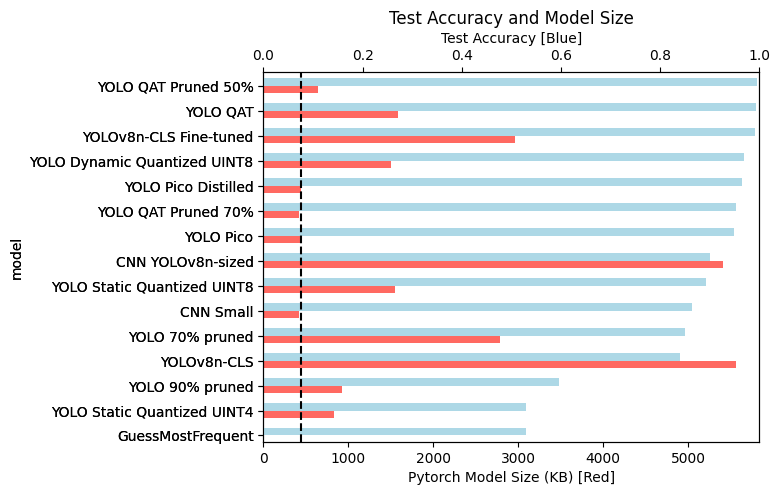

In [34]:
# horizontal bar plot including both pytorch size and test accuracy
fig, ax = plt.subplots()

# use onnx as default for nan pytorch size
df_filled = df_results.copy()
df_filled['pytorch_size_kb'] = df_results['pytorch_size_kb'].fillna(df_results['onnx_size_kb'])

df_filled.plot(kind='barh', x='model', y='pytorch_size_kb', ax=ax, color='#FF6961', legend=False, position=1, width=0.3)
ax.set_xlabel('Pytorch Model Size (KB) [Red]')

ax2 = ax.twiny()
df_filled.plot(kind='barh', x='model', y='test_accuracy', ax=ax2, color='#ADD8E6', legend=False, position=0, width=0.3)
ax2.set_xlabel('Test Accuracy [Blue]')
ax2.set_xlim(0, 1)

# vertical line at x = TARGET_SIZE
ax2.axvline(x=TARGET_SIZE / ax.get_xlim()[1], color='k', linestyle='--')

plt.title('Test Accuracy and Model Size')
plt.savefig('../data/test_accuracy_and_model_size.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [35]:
display(df_results)

,model,test_animal_accuracy,test_non_animal_accuracy,test_accuracy,pytorch_size_kb,onnx_size_kb
0,GuessMostFrequent,1.000000,0.000000,0.530170,0.000,0.000
1,YOLO Static Quantized UINT4,1.000000,0.000000,0.530170,NaN,834.379
2,YOLO 90% pruned,0.422099,0.790524,0.595196,929.250,NaN
3,YOLOv8n-CLS,0.879558,0.795511,0.840070,5563.076,10905.376
4,YOLO 70% pruned,0.839227,0.864090,0.850908,2784.204,NaN
5,CNN Small,0.923204,0.797382,0.864089,414.018,NaN
6,YOLO Static Quantized UINT8,0.833702,0.956983,0.891623,NaN,1551.399
7,CNN YOLOv8n-sized,0.870166,0.935786,0.900996,5414.498,NaN
8,YOLO Pico,0.934254,0.966958,0.949619,442.000,NaN
9,YOLO QAT Pruned 70%,0.930939,0.976309,0.952255,414.577,NaN


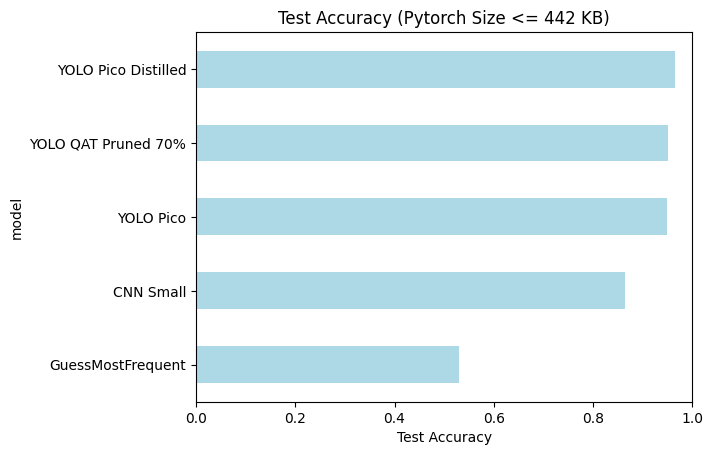

In [36]:
# only show models with pytorch size less than or equal to TARGET_SIZE
df_small_results = df_results[df_results['pytorch_size_kb'] <= TARGET_SIZE]

# horizontal bar plot including both pytorch size and test accuracy
df_small_results.plot(kind='barh', x='model', y='test_accuracy', color='#ADD8E6', legend=False)
plt.xlabel('Test Accuracy')
plt.xlim(0, 1)

plt.title(f'Test Accuracy (Pytorch Size <= {TARGET_SIZE} KB)')
plt.savefig('../data/test_accuracy_and_model_size_small.png', bbox_inches='tight', pad_inches=0.1)
plt.show()